# K-means algorithm and Cluster Validation


> **NOTE**: When running a cell, please make sure to run all the cells above first, as not doing so might cause the code to fail

# Necessary imports and setup

We start by importing the necessary libraries as well as setting up appropriate styles for the plots for both parts of the project

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
import copy

plt.style.use('default')
plt.style.use('dark_background')

# Implementing k-means algorithm with Mahalanobis Distance

## Toy dataset generation

Before running any algorithms, we first need to generate a toy dataset that can effectively demonstrate the difference between using Mahalanobis and Euclidean distances for k-means clustering.

#### Generating ellipse shaped data

The ellipse shaped data generation builds upon the parametric equation of a rotated ellipse, which is as follows:   
$$x = a \cos t \cos \theta - b \sin t \sin \theta$$
$$y = a \cos t \sin \theta + b \sin t \cos \theta$$

Where,  
   
$a$ = major radius of the ellipse   
$b$ = minor radius of the ellipse   
$t$ = parameter to get a point $(x, y)$ on ellipse   
$\theta$ = angle of rotation of the ellipse
   
Now, using these equations, we can generate points on a rotated ellipse centered at $(0, 0)$. But, for clustering, we need data points that are not just on the ellipse, but rather make an ellipse shaped blob collectively. To achieve this, we multiply each point obtained using the above equations with a random number chosen from a **normal distribution**. The normal distribution with mean zero ensures that most points are closer to the center of the ellipse, while the variance gives the necessary spread to the data.   
   
At this point, we have an ellipse shaped data blob centered at $(0, 0)$ and rotated at some angle. Finally, we move the center of this data by adding coordinates of the new center $(h, k)$ to the $x$ and $y$ obtained in earlier steps.   
    
Generating such $(x, y)$ for the required number of points gives the required dataset. This concludes ellipse shaped data generation.

In [2]:
def gen_ellipse_shaped_data(scale_factor, a, b, h, k, angle, num_points):
    """
    Generates an ellipse shaped dataset
    
    :param scale_factor: Scale factor of the ellipse (Bigger scale factors allow bigger ellipses)
    :param a: major radius of the ellipse
    :param b: minor radius of the ellipse
    :param h: x coordinate of the ellipse's center
    :param k: y coordinate of the ellipse's center
    :param angle: angle of rotation of the ellipse
    :param num_points: number of data points to be generated
    
    :returns: ellipse shaped dataset with the given arguments
    """
    points = [] # initially, no points
    
    for i in range(num_points):
        # getting x and y using the parametric equations of rotated ellipse
        # also multiplying the scale_factor for bigger ellipses
        x = scale_factor*(a*np.cos(i)*np.cos(angle) - b*np.sin(i)*np.sin(angle))
        y = scale_factor*(a*np.cos(i)*np.sin(angle) + b*np.sin(i)*np.cos(angle))
        
        # generating a random float from normal distribution with mean at 0 and a variance of 0.5
        random_fl = np.random.normal(loc=0.0, scale=0.5)
        
        # multipying the point on ellipse with a random number from the above distribution. Also
        # translating it to the new center
        x = x*random_fl + h
        y = y*random_fl + k
        
        # appending the final point
        points.append([x, y])
    
    return points

#### Generating dataset containing data from multiple ellipse shaped blobs

Once we have the code to generate an ellipse shaped data blob, we can now generate our toy dataset which combines multiple ellipse shaped blobs and returns it as a single dataset. In addition, we also return the actual means of each individual blobs, which will later be used in comparing the results obtained from k-means to the actual individual ellipse blobs.

The ```generate_clustering_dataset``` function below generates the required dataset.
  
Here, also note that the additional function ```calc_dataset_mean``` calculates the mean of the provided data points. This function will also used later in the k-means algorithm for updating the cluster means.

In [3]:
def calc_dataset_mean(dataset):
    """
    Calculates the mean of the provided dataset
    
    :param dataset: The input dataset
    
    :returns: The mean of the dataset
    """
    if len(dataset) < 1:
        # empty dataset should not have any mean
        return None
    
    mean = [0.0]*len(dataset[0])
    
    # adding averaged value of each point to the mean
    for point in dataset:
        for i, coord in enumerate(point):
            mean[i] += coord / len(dataset)
            
    return mean

def generate_clustering_data(num_points, seed=None):    
    """
    Generates a 2D clustering data with required number of points
    
    :param num_data_points: Number of points in the required dataset
    :param seed: Seed to be used for the random generator 
    
    :returns: A 2D dataset with required number of points
    """
    np.random.seed(seed)
    ellipse_data_1 = gen_ellipse_shaped_data(0.45, 4, 1, 0.0, -1.1, np.radians(-60), num_points // 4)
    ellipse_data_2 = gen_ellipse_shaped_data(0.45, 4, 1, 0.5, 0.0, np.radians(-60), num_points // 4)
    ellipse_data_3 = gen_ellipse_shaped_data(0.45, 4, 1, 1.0, 1.1, np.radians(-60), num_points // 4)
    ellipse_data_4 = gen_ellipse_shaped_data(0.65, 1, 1, 1.75, 1.75, np.radians(0), num_points // 4)
    
    # combining the four datasets into one
    combined = ellipse_data_1 + ellipse_data_3 + ellipse_data_2 + ellipse_data_4
    
    # also keeping track of actual means for later comparisions and experiments
    actual_means = [calc_dataset_mean(ellipse_data_1), calc_dataset_mean(ellipse_data_2),\
                    calc_dataset_mean(ellipse_data_3), calc_dataset_mean(ellipse_data_4)]
    
    return combined, actual_means

## Utility Functions

#### Euclidean Distance calculation

The Euclidean between two points $x$ and $y$ is calculated using the following equation:  
  
$$d(x, y) = \sqrt{\left\| x - y \right\|^2}$$
   
Since the k-means algorithm only uses the distances for comparisions, the k-means algorithm can work with the squared distances as well, because the squared distances will have the same minimum or maximum. However, here we take the square root for the consistency and reusability of the same function in the cluster validation part.   

Since the calculation of Davies-Bouldin index relies upon actual euclidean distances and not their squares, this function can provide correct values.

In [4]:
def calc_euclidean_distance(point1, point2):
    """
    Calculates the euclidean distance between two points
    
    :param point1: Point 1 for distance calculation
    :param point2: Point 2 for distance calculation
    
    :returns: The euclidean distance between two points
    """
    # checking if any of the points are None. Also checking if the points have same dimensions.
    if not point1 or not point2 or len(point1) != len(point2):
        return None
    
    euc_dist = 0.0
    
    for coord1, coord2 in zip(point1, point2):
        # addiing the squared difference for each coordinate
        euc_dist += (coord1 - coord2)**2

    return np.sqrt(euc_dist)

#### Covariance Matrix Calculation

For the Mahalanobis distance based ***k-means***, we need to calculate the covariance matrix of the data as well. Covariance is the measure of association between two variables.
  
The covariance of $N$ samples consisting two variables $x$ and $y$ with means $\bar{x}$ and $\bar{y}$ is calculated using the following equation:
  
$$cov(x, y) = \frac{1}{N-1}\sum_{i=1}^{N} (x_i - \bar{x})(y_i - \bar{y})$$  

The resulting covariance matrix is an $V\times V$ square matrix for data constisting of $V$ variables, where each cell describes the covariance between the row and the column variable. For example, a covariance matrix of two variables $x$ and $y$ is:
$\begin{bmatrix}
cov(x, x) & cov(x, y)\\
cov(y, x) & cov(y, y)
\end{bmatrix}$
   
   Notice that, Since $cov(a, b)$ is the same as $cov(b, a)$, the matrix is symmetric. Also, since $cov(a, a)$ is just the variance of a, the diagonal values are the variances of individual variables.  
  
  
As numpy has the functionality of calculating covariance on a provided data, we use that function for simplicity. Note that the data is a list of lists, where each element of the input data is an N-dimensional points. Since the numpy covariance calculation requries each column of its input to a coordinate (e.g. first column indicating the x coordinate of the points), it is necessary to take the transpose first, as shown in the code below.

In [5]:
def calc_covariance(data):
    """
    Calculates the covariance of the input data
    
    :param data: input data
    
    :returns: The covariance matrix of the input data (NxN matrix for N dimensional data)
    """
    data_np = np.array(data) # converting the data to np array before doing any operations
    data_np_transpose = data_np.T # taking transpose of the data
    cov_matrix = np.cov(data_np_transpose) # calculating the covariance matrix using the transpose  
    return cov_matrix

#### Mahalanobis Distance Calculation

For the mahalanobis distance based ***k-means*** algorithm, we need a function that calculates the Mahalanobis distance between a sample point and a cluster. In contrast to the Euclidean distance, Mahalanobis distance takes the covariance of the variables in the data as well into consideration.
  
The Mahalanobis distance $d_M$ between a point $x$ and a cluster $\mathcal{C}$ with covariance matrix $\mathcal{S}$ and mean $\mu$ is calculated using the following equation:

$$d_M(x, \mathcal{C}) = \sqrt{(x - \mu)^{T} \mathcal{S}^{-1} (x - \mu)}$$

In [6]:
def calc_mahalanobis_distance(sample, cov_matrix, mean):
    """
    Calculates the mahalanobis distance between a sample and a cluster
    
    :param sample: input sample
    :param cov_matrix: covariance matrix of the cluster
    :param mean: The mean of the cluster
    
    :returns: Mahalanobis distance between the cluster and the sample
    """
    # casting to numpy array for numpy operations
    sample_np = np.array(sample)
    mean_np = np.array(mean)
    
    diff = sample_np - mean_np
    
    # getting the inverse covariance matrix
    if np.linalg.det(cov_matrix) != 0:
        # the inverse of a matrix only exists if the determinant is not 0
        inverse_cov_matrix = np.linalg.inv(cov_matrix)
    else:
        # if the determinant is 0, use an identity matrix as the inverse covariance matrix instead
        # Mathematically, when identity matrix is used as the inverse covariance matrix in Mahalanobis
        # distance, it is equal to the Euclidian distance between the point and the cluster's mean
        inverse_cov_matrix = np.identity(2)
        
    # doing the required dot products to calculate the Mahalanobis distance
    temp = np.dot(diff.T, inverse_cov_matrix)
    mahal_dist = np.dot(temp, diff)

    return np.sqrt(mahal_dist)

#### Finding nearest cluster based on specified distance

Now that we have the functions for calculating the Euclidean and the Mahalanobis distances, we can write the function that finds the nearest cluster using either of these distances. The k-means algorithm will use this function to find the cluster that is nearest to the sample, and it will put the sample point into that cluster.
   
Note that, when there is only one point in a cluster, the nearest distance is always calculated as the euclidean distance. This is because, when $N = 1$, the covariance of the data is not defined because of the term $\frac{1}{N-1}$ in its equation.

In [7]:
def get_nearest_cluster(sample, clusters, means, mahalanobis):
    """
    Finds the nearest cluster to the input sample based on the distance 
    specified (Mahalanobis or Euclidean)
    
    :param sample: input sample point
    :param clusters: clusters in the partition 
    :param means: Means of the clusters
    :param mahalanobis: boolean value indicating if mahalanobis distance is to 
                        be used instead of euclidean distance
    
    :returns: The nearest cluster to the sample based on the distance
              specified (Mahalanobis or Euclidean)
    """
    min_distance = sys.float_info.max
    nearest_cluster = -1
    for i, cluster in enumerate(clusters):
        if len(cluster) < 2 or not mahalanobis:
            # If there is only 1 point in the cluster,
            # always use euclidian distance 
            distance = calc_euclidean_distance(sample, means[i])
        else:
            cov_matrix = calc_covariance(cluster)
            distance = calc_mahalanobis_distance(sample, cov_matrix, means[i])
        if distance < min_distance:
            # new nearest cluster found, update the known minimums accordingly
            min_distance = distance
            nearest_cluster = i
    return nearest_cluster

#### Choosing random means

In the first iteration, the k-means algorithm chooses the cluster representatives randomly to start clustering the data. This function returns unique random points from the input data as initial representatives. Although these are called "means" for keeping the naming consistent with k-means, these are not necessarily the actual means of the data, but rather just some random points in the dataset.   
   
Since these randomly chosen representatives are the starting point of clustering in k-means, their values have a huge impact on the final result.

In [8]:
def get_random_means(input_data, k):
    """
    Chooses random means from the input data
    
    :param input_data: input data
    :param k: number of means to choose
    
    :returns: Random points from the input dataset which will be interpreted as
              initial representatives of the clusters
    """
    random_means = []
    random_indexes = []
    
    for i in range(k):
        while True:
            new_random_index = np.random.randint(0,len(input_data)-1)
            if new_random_index not in random_indexes:
                # new random index found
                random_indexes.append(new_random_index)
                break
    # get random means from the data using the random indexes
    for rand_index in random_indexes:
        random_means.append(input_data[rand_index])
    
    return random_means

## K-means Algorithm

Now that we have all the required pieces together, we can finally write the k-means algorithm for k-clustering.   
   
The ***k-means*** algorithm takes the input data $\mathcal{X} = {x_1,..., x_n}$, the number of clusters $k$, and the maximum number of iterations. Note that, the function ```k_means``` takes an additional boolean argument ```mahalanobis``` indicating if the algorithm should use mahalanobis distances instead of euclidean distances.  
   

The output of the k-means algorithm is a partition $\mathcal{P} = \{{\mathcal{C}_1,..., \mathcal{C}_K}\}$, where    
   - each initial data point $x \in \mathcal{X}$ is in some cluster $\mathcal{C} \in \mathcal{P}$
   - no cluster $\mathcal{C} \in \mathcal{P}$ is $\phi$
   - $\bigcup^{K}_{i=1} = \mathcal{P}$
   - $\bigcup^{K}_{i=1} = \mathcal{P}$
   - $C_i \cap C_j = \phi, i \neq j, i, j = 1, ..., K$
 

In [9]:
def k_means(data, k, max_iterations, mahalanobis):
    """
    The k-means algorithm. Clusters the input data into number of clusters
    provided (k)
    
    :param data: data to be clustered
    :param k: number of clusters for partitioning
    :param max_iterations: maximum number of iterations for the k-means algorithm
    :param mahalanobis: boolean specifying if k-means should use mahalanobis 
                        distance instead of standard euclidean distance
    
    :returns: Partition of the input data, consisting k-clusters, 
              means of each cluster in the partition,
              number of iterations taken by the k-means for clustering
    """
    partition = [[] for i in range(k)]   # number of clusters in partition is k
    means = get_random_means(data, k)   # initial cluster representatives, chosen randomly
    last_partition = None  # last partition, to detect convergence
    t = 0
    while True:
        t += 1
        last_partition = partition  # storing the partition before changing
        partition = [[] for i in range(k)]
        for sample in data:
            # getting nearest cluster
            nearest = get_nearest_cluster(sample, last_partition, means, mahalanobis)
            # appending sample to the nearest cluster
            partition[nearest].append(sample)
        for i, cluster in enumerate(partition):
            # updating the means
            if len(cluster) > 0:
                means[i] = calc_dataset_mean(cluster)
        if partition == last_partition or t > max_iterations:
            # convergence of maximum iterations reached
            return partition, means, t

### Utility function for plotting a partition

In [10]:
def plot_clusters(partition, means, ax, title):
    """
    Plots the clusters using matplotlib
    
    :param partition: partition to plot
    :param means: list of mean of each cluster in the partition
    :param ax: matplotlib axes to plot on
    :param title: title of the axes
    """
    ax.set_title(title)
    colors = ['red', 'goldenrod', 'turquoise', 'limegreen']
    cmap = plt.get_cmap('gist_rainbow')
    colors += [cmap(i) for i in np.linspace(0, 1, 100)]
    for i, cluster in enumerate(partition):
        x = [point[0] for point in cluster]
        y = [point[1] for point in cluster]
        ax.plot(x, y, '.', color=colors[i])

    x = [point[0] for point in means]
    y = [point[1] for point in means]
    ax.plot(x, y, 'o', color='white')
    ax.axis('square')

## Running the k-means algorithm

With all the algorithms and functions ready, we can now run the k-means algorithm.

#### Generating data

The first step is to generate data using the generation function above. Note that, since the generator also uses the random number generator, the data generated using the seed below was found to be the best for clustering. However, a different seed can be used to generate different data, but due to the randomness, the results might not be as good.
   
   
Here, also note that the actual_means are stored only for comparision after the clustering. The k-means algorithm has absolutely no reference about the actual means, or number of shapes used when generating the data. 

In [11]:
# Generating data using the data generation function
clustering_data, actual_means = generate_clustering_data(600, seed=4)

#### Setting up the parameters for k-means

Since we generated dataset using 4 ellipse shaped blobs, $k=4$ is the natural choice for number of clusters.

In [12]:
k = 4 # the number of clusters
max_iterations = 20   # maximum iterations for the k-means algorithm

#### Running k-means with the generated data and given parameters

Here, note that there are random seeds used for both the Euclidean and the Mahalanobis distance versions of ***k-means***. This is because the intial random choice of the cluster representatives has a huge impact on the final results. These seeds were found to produce good results while experimenting, and different seeds might produce worse results.

Clustering using Euclidean distances...
Euclidian distance based k-means took 7 iterations for k = 4
Clustering using Mahanalobis distances...
Mahalanobis distance based k-means took 11 iterations for k = 4
Clustering done!


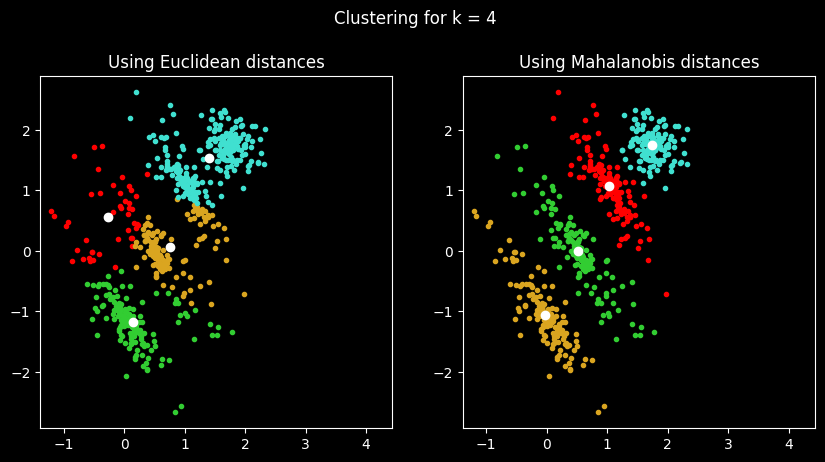

In [13]:
np.random.seed(25)   # the random seed that was found to produce good results for eulidean k-means
print("Clustering using Euclidean distances...")
# calling the k-means algorithm with euclidean distances on the data
euc_partition, euc_means, euc_iterations = k_means(clustering_data, k, \
                                                        max_iterations, mahalanobis=False)
print("Euclidian distance based k-means took {} iterations for k = {}".format(euc_iterations, k))

np.random.seed(10) # the random seed that was found to produce good results for mahalanobis k-means
print("Clustering using Mahanalobis distances...")
# calling the k-means algorithm with mahalanobis distances on the data
mahal_partition, mahal_means, mahal_iterations = k_means(clustering_data, k, \
                                                        max_iterations, mahalanobis=True)
print("Mahalanobis distance based k-means took {} iterations for k = {}".format(mahal_iterations, k))

print("Clustering done!")

# figure and axes for plotting the clusters
figure, axs = plt.subplots(1, 2, figsize=(10, 5))
figure.suptitle("Clustering for k = {}".format(k))

# plotting the clusters calculated using euclidean based k-means
plot_clusters(euc_partition, euc_means, axs[0], "Using Euclidean distances")

# plotting the clusters calculated using euclidean based k-means
plot_clusters(mahal_partition, mahal_means, axs[1], "Using Mahalanobis distances")

plt.show()

## Observations and Experiments: Mahalanobis vs. Euclidean distances for k-means

As we can see in the above plots, the Mahalanobis distance based k-means produces much superior results than its Euclidean distance based counterpart. This is because of the covariance consideration in Mahalanobis distance calculation. While the points might be closer in the euclidean space, ellipse shaped data has a covariance between the $x$ and $y$ coordinates. So, data points that have similar covariance should belong to the same cluster, which is successfully done using Mahalanobis distances. However, the Euclidean distance based k-means fails to capture the covariance, and produces clusters that look 'spherical', because it is only suitable for clusters that can be modeled by *hyper-spheres*, while our input data is *hyper-ellipsodial*.
    
Note that, the random seeds of data generation and intial representative choice can give drastically different end results.

### Comparision of actual means and means of final clusters with Mahalanobis and Euclidean distances

We can also compare the results of each of the k-means algorithm with the actual means that were calculated at the time of data generation. The following code plots all three kinds of means for comparision purposes.

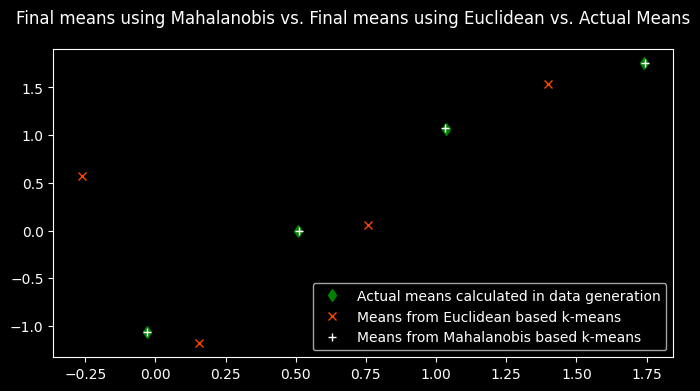

In [14]:
# This code plots the actual means kept from the data generation, the final means of euclidean based
# k-means and the final means of mahanalobis based k-means
figure2 = plt.figure(figsize=(8, 4))
figure2.suptitle("Final means using Mahalanobis vs. Final means using Euclidean vs. Actual Means")

# plotting the actual means that were calculated at the time of data-generation
actual_means_x = [mean[0] for mean in actual_means]
actual_means_y = [mean[1] for mean in actual_means]
plt.plot(actual_means_x, actual_means_y, 'd', color='green')

# plotting the final means of partition obtained with euclidean distance based k-means
euc_means_x = [mean[0] for mean in euc_means]
euc_means_y = [mean[1] for mean in euc_means]
plt.plot(euc_means_x, euc_means_y, 'x', color='orangered')

# plotting the final means of partition obtained with mahalanobis distance based k-means
mahal_means_x = [mean[0] for mean in mahal_means]
mahal_means_y = [mean[1] for mean in mahal_means]
plt.plot(mahal_means_x, mahal_means_y, '+', color='white')

plt.legend(["Actual means calculated in data generation", "Means from Euclidean based k-means", "Means from Mahalanobis based k-means"], loc ="lower right")
plt.show()

As the above plot shows, there is minimal difference between the means of actual ellipse shapes and the means of clusters produced by the Mahalanobis distance based k-means. In contrast, the Euclidean based k-means produced means that are far from the means of actual shapes, indicating that the clustering done by it is not close to optimal.

# Part 2: Cluster validation using Davies-Bouldin Index

## Utility Functions

#### Loading data from a file

In [15]:
def load_data_from_file(filename):
    """
    Loads clustering data from a file
    
    :param filename: Name of the file to load data from
    
    :returns: A list containing each point in the data, where point is also a list of its
             coordinates (e.g. if file has two points 0.5,0.5 and 1.0,1.0, the final list
             is [[0.5,0.5], [1.0,1.0]])
    """
    points = []
    with open(filename, 'r') as fp:
        lines = fp.readlines() # reading all the lines at once
        # going through each line to extract data
        for line in lines:
            coords = line.split(',')  # splitting on a comma
            new_point = []
            for coord in coords:
                new_point.append(float(coord.strip()))  # converting the string values to float
            points.append(new_point)
    
    return points

#### Calculating distance within cluster

Distance within the cluster is the average distance of each data point from the centroid of the cluster. It gives a measure of the spread of the cluster, where higher within distance means a larger spread and vice versa. Distance within a cluster $c$ with centroid $\mu_c$ and $N$ points can be calculated using the following equation:

$$\bar{d_c} = \frac{1}{N}\sum_{i=1}^{N}{d(x_i, \mu_c)}$$

In [16]:
def calc_within_cluster_dist(cluster, cluster_centroid):
    """
    Calculates the 'within-distance' of a cluster
    
    :param cluster: input cluster
    :param cluster_centroid: centroid of the cluster
    
    :returns: Average distance between each point in the cluster from its centroid
    """
    avg_distance = 0.0
    for point in cluster:
        avg_distance += calc_euclidean_distance(point, cluster_centroid)
    avg_distance /= len(cluster)  # dividing at the end
    return avg_distance

## Davies-Bouldin Index for cluster validation

As we saw in part 1, choosing the number of clusters $k$ for k-means is not a trivial task. A bad choice of $k$ can give worse clusters, and choosing a $k$ that is more suitable for the input data is essential for effective clustering. The Davies-Bouldin Index for cluster validation is a metric that determines the ideal number of clusters in a data. It uses the distance within the individual clusters as well as distance between the clusters to generate an index. The Davies-Bouldin Index of a partition $\mathcal{C}$ with $k$ clusters is calculated using the following equation:

$$DB(\mathcal{C}) = \frac{1}{k} \sum_{i=1}^{k}{\max_{j \leq k, j \neq i} D_{ij}}, k = |\mathcal{C}|$$

    
    
Where,
$$D_{ij} = \frac{(\bar{d_i}+\bar{d_j})}{d_{ij}}$$
where $\bar{d_i}$ and $\bar{d_j}$ are within distances of clusters $i$ and $j$, and  $d_{ij}$ is the distance between the centroids of the clusters $i$ and $j$

   The number of clusters $k$ which minimizes the Davies-Bouldin index is considered to be the best number of clusters suitable for the input data.


In [17]:
def calc_davies_bouldin_index(partition, centroids):
    """
    Calculates the Davies-Bouldin index for a given partition
    
    :param partition: input partition
    :param centroids: centroids of the clusters in partition
    
    :returns: Davies-Bouldin index of the input partition
    """
    k = len(partition)
    max_distances = [0.0]*k
    within_dists = [calc_within_cluster_dist(cluster, centroid) \
                    for cluster, centroid in zip(partition, centroids)]
    for i, cluster_i in enumerate(partition):
        max_distance = 0
        for j, cluster_j in enumerate(partition):
            if j == i:
                continue
            distance_between = calc_euclidean_distance(centroids[i], centroids[j])
            distance = within_dists[i] / distance_between
            if distance > max_distance:
                max_distance = distance
        max_distances[i] = max_distance
    db_index = sum(max_distances) / k
    return db_index

## Simulating k-means with Davies Bouldin Index

#### Loading data from the file

We first load the validation data from the file. Note that this requires the file ```cluster_validation_data.txt``` to be in the same directory as this notebook.

In [18]:
validation_data = load_data_from_file("cluster_validation_data.txt")

FileNotFoundError: [Errno 2] No such file or directory: 'cluster_validation_data.txt'

#### Setting up the parameters for k-means

As previously, the below random seed was found to produce good results. Changing the seed will give different results.

In [ ]:
np.random.seed(25)
max_validation_k = 20
max_validation_iters = 100
validation_ks = [i for i in range(2, max_validation_k+1)]

#### Simulating Euclidean based k-means to find the best partition 

We run the k-means algorithm with euclidean distance with number of clusters upto the specified ```max_validation_k```, and observe the results below.

In [ ]:
print("Running cluster validation with Euclidean distances for k upto {}\n".format(max_validation_k))

davies_bouldin_indexes = []
min_index = sys.float_info.max
best_partition = []
best_means = []
best_k = -1

# running the k-means algorithm for k upto max validation, keeping track of the best partition found
# at each validation k
for validation_k in range(2, max_validation_k + 1):
    partition, means, iterations = k_means(validation_data, validation_k, max_validation_iters, mahalanobis=False)
    db_index = calc_davies_bouldin_index(partition, means)
    if db_index < min_index:
        # new best partition found
        min_index = db_index
        best_partition = partition
        best_means = means
        best_k = validation_k
    davies_bouldin_indexes.append(db_index)
    print("Clustering with k = {} took {} iterations".format(validation_k, iterations))

# figure to plot the davies bouldin indexes of validation k's
figure, axs = plt.subplots(1, 2, figsize=(12, 5))
figure.suptitle("Cluster validation with Davies-Bouldin Index")

# plotting the Davies-Bouldin values
axs[0].set_title("Davies-Bouldin Indexes vs. number of clusters(k)")
axs[0].plot(validation_ks, davies_bouldin_indexes, '-', color='grey')
axs[0].plot(validation_ks, davies_bouldin_indexes, '.', color='turquoise')
axs[0].set_xlabel("Number of clusters (k)")
axs[0].set_ylabel("Davies-Bouldin Values")
axs[0].set_xticks(validation_ks)

# plotting the best partition
plot_clusters(best_partition, best_means, axs[1], \
              "Best partition (k={}) with minimum Davies-Bouldin Index".format(best_k))

plt.show()

## Observations and Experiments: Davies Bouldin Index

As it can be seen from the above plots, 3 is the optimal number of clusters for the given validation data as it has the minimum Davies-Bouldin Index. When the ```max_validation_k``` is changed to larger values, it is also observed that the Davies-Bouldin Index does not change much after a certain number of k's. This is because as the number of clusters increases, the clusters become smaller and get closer. For larger values, these numbers have a less tendency of varying too much, which in turn makes the ratio relatively less volatile than smaller k's.